In [1]:
import json
import numpy as np
import h5py
import tensorflow as tf
import os
import cPickle as pkl
#import ipdb
import numpy
import copy
import pprint
from Recognizer import MathFormulaRecognizer
import warnings
import sys
import math
import time
from util import *
from collections import OrderedDict

from data_iterator import dataIterator
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
home_path = os.getcwd()
checkpoint_path = os.path.join(home_path,'save')
max_iters = 100000
batch_size = 8
valid_batch_size = 2
finetune_encoder_after = -1
#Evaluation Checkpoint
nEvaImages = 300
EvaEach = 2500
SummaryEach = 1000
device = "/gpu:0"
batch_Imagesize=250000
valid_batch_Imagesize=250000
maxImagesize = 500000
maxlen = 200
n_epoch = 10000

In [3]:
#build model
model = MathFormulaRecognizer(num_label =112,dim_hidden=128,device = '/device:GPU:0')
alpha_t,beta_t,state,logit = model.build_eval()
saver = tf.train.Saver(max_to_keep=10)
sess = tf.Session()
saved_path=tf.train.latest_checkpoint(checkpoint_path)
tf.reset_default_graph()
saver.restore(sess, saved_path)

In [4]:
datasets=['./data/offline-train.pkl',
'./data/train_caption.txt']
valid_datasets=['./data/offline-test.pkl',
'./data/test_caption.txt']
dictionaries=['./data/dictionary.txt']


worddicts = load_dict(dictionaries[0])
worddicts_r = [None] * len(worddicts)

for kk, vv in worddicts.iteritems():
        worddicts_r[vv] = kk
train,train_uid_list = dataIterator(datasets[0], datasets[1],
                         worddicts,
                         batch_size=batch_size, batch_Imagesize=batch_Imagesize,maxlen=maxlen,maxImagesize=maxImagesize)
valid,valid_uid_list = dataIterator(valid_datasets[0], valid_datasets[1],
                     worddicts,
                     batch_size=valid_batch_size, batch_Imagesize=valid_batch_Imagesize,maxlen=maxlen,maxImagesize=maxImagesize)


total words/phones 111
total  1779 batch data loaded
sentence 505_em_51 length bigger than 200 ignore
total  505 batch data loaded


In [48]:
def softmax(x):
    return np.exp(x) / np.sum(np.exp(x), axis=0)
ind = 678
valid = np.squeeze(valid)
train = np.squeeze(train)
n_valid_img = valid.shape[0]
x, x_mask, y, y_mask = prepare_data(train[ind,0],train[ind,1])
x = x[0:1,:,:,:]
x_mask = x_mask[0:1,:,:]

Alpha,Beta,State,Logit,information_tensor,vec_mask,sx_mask \
            = sess.run([alpha_t,beta_t,state,logit,model.information_tensor,model.vec_mask,model.sx_mask],\
            feed_dict={model.x:x,model.x_mask:x_mask,model.is_train:False})

orders = np.argsort(Logit[0])[::-1]
probs = softmax(Logit[0])
inds = orders[0:5]
probs = np.log(probs[inds])
result = [[ind] for ind in inds]
print(inds)

[102  61  56  35 106]


In [49]:
beams = []
temp_structure = []
for i in range(0,5):
    previous_word = np.expand_dims(np.asarray(result[i][0]),0)
    
    tAlpha,tBeta,tState,tLogit = sess.run([alpha_t,beta_t,state,logit],feed_dict=\
                                          {model.information_tensor:information_tensor,model.vec_mask:vec_mask,\
                                            model.in_alpha_t:Alpha,model.in_beta_t:Beta,model.sx_mask:sx_mask,\
                                            model.in_state:State,model.in_previous_word:previous_word,model.is_train:False})
    
    orders = np.argsort(tLogit[0])[::-1]
    tprobs = softmax(tLogit[0])
    inds = orders[0:5]
    tprobs = np.log(tprobs[inds])
#     print(tprobs)
    for j in range(0,5):
        temp_structure.append([np.copy(tAlpha),np.copy(tBeta),np.copy(tState),result[i]+[inds[j]],tprobs[j]+ probs[i]])
a = sorted(temp_structure, key=lambda x: x[4], reverse=True)
cur_beam = a[0:5]

finish_flag = False
latex_array = ''
for j in range(0,5):
    print(cur_beam[j][3])
    if(cur_beam[j][3][1] == 0):
        latex_array = cur_beam[j][3]
        finish_flag = True  
        break


[102, 47]
[61, 47]
[102, 106]
[102, 80]
[56, 106]


In [50]:
iter_num = 2
while(True):
    temp_structure = []
    if finish_flag:
        break
    for i in range(0,5):
#         print(cur_beam[i][3])
        previous_word = np.expand_dims(np.asarray(cur_beam[i][3][iter_num-1]),0)
        Alpha = cur_beam[i][0]
        Beta = cur_beam[i][1]
        State = cur_beam[i][2]
        tAlpha,tBeta,tState,tLogit = sess.run([alpha_t,beta_t,state,logit],feed_dict=\
                                              {model.information_tensor:information_tensor,model.vec_mask:vec_mask,\
                                                model.in_alpha_t:Alpha,model.in_beta_t:Beta,model.sx_mask:sx_mask,\
                                                model.in_state:State,model.in_previous_word:previous_word,model.is_train:False})
        orders = np.argsort(tLogit[0])[::-1]
        tprobs = softmax(tLogit[0])
        inds = orders[0:5]
        tprobs = np.log(tprobs[inds])
#     print(tprobs)
        for j in range(0,5):
            temp_structure.append([np.copy(tAlpha),np.copy(tBeta),np.copy(tState),cur_beam[i][3]+[inds[j]],tprobs[j]+ cur_beam[i][4]])
    a = sorted(temp_structure, key=lambda x: x[4], reverse=True)
    cur_beam = a[0:5]
#     print(cur_beam[0][3])
    for j in range(0,5):
        print(cur_beam[j][3])
        if(cur_beam[j][3][iter_num] == 0):
            latex_array = cur_beam[j][3]
            finish_flag = True
            break
    iter_num += 1


[102, 47, 57]
[61, 47, 57]
[102, 106, 47]
[102, 80, 47]
[56, 106, 47]
[102, 47, 57, 79]
[102, 47, 57, 106]
[102, 47, 57, 90]
[102, 106, 47, 57]
[61, 47, 57, 79]
[102, 47, 57, 79, 110]
[102, 47, 57, 106, 110]
[102, 47, 57, 79, 34]
[102, 47, 57, 90, 110]
[102, 47, 57, 79, 93]
[102, 47, 57, 79, 110, 34]
[102, 47, 57, 106, 110, 93]
[102, 47, 57, 79, 110, 93]
[102, 47, 57, 79, 34, 90]
[102, 47, 57, 79, 110, 61]
[102, 47, 57, 79, 110, 34, 79]
[102, 47, 57, 79, 110, 34, 106]
[102, 47, 57, 79, 34, 90, 110]
[102, 47, 57, 79, 110, 34, 6]
[102, 47, 57, 79, 110, 34, 26]
[102, 47, 57, 79, 110, 34, 79, 47]
[102, 47, 57, 79, 110, 34, 106, 47]
[102, 47, 57, 79, 34, 90, 110, 34]
[102, 47, 57, 79, 110, 34, 6, 79]
[102, 47, 57, 79, 110, 34, 26, 47]
[102, 47, 57, 79, 110, 34, 79, 47, 57]
[102, 47, 57, 79, 110, 34, 106, 47, 57]
[102, 47, 57, 79, 110, 34, 6, 79, 89]
[102, 47, 57, 79, 110, 34, 26, 47, 57]
[102, 47, 57, 79, 34, 90, 110, 34, 6]
[102, 47, 57, 79, 110, 34, 106, 47, 57, 79]
[102, 47, 57, 79, 110,

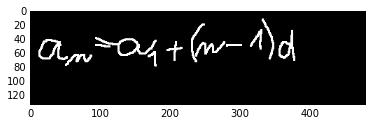

In [51]:
im =np.squeeze(x[0])
plt.imshow(np.squeeze(im),cmap='gray')

[102, 47, 57, 79, 110, 34, 6, 79, 89, 90, 88, 22, 0]
a_{n}+(n-1)d


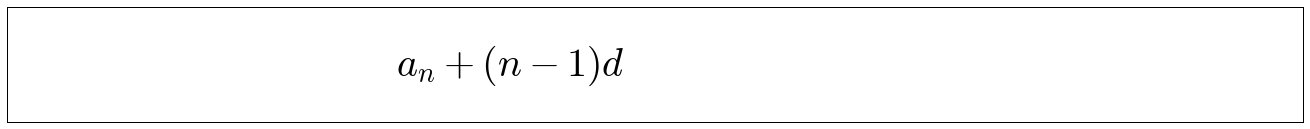

In [52]:
to_print = ''
print(latex_array)
for i in range(0,len(latex_array)-1):
    to_print = to_print + (worddicts_r[latex_array[i]])
print(to_print)
ax = plt.axes([0,0,3.0,0.4]) #left,bottom,width,height
ax.set_xticks([])
ax.set_yticks([])
plt.text(0.3,0.4,'$%s$' %to_print,size=40)

# plt.imshow(np.reshape(att[0][0],[height,width]),cmap='gray')

In [ ]:
# import matplotlib.pyplot as plt
# a = '\\frac{a}{b}'  #notice escaped slash
# plt.plot()
# plt.text(0.5, 0.5,'$%s$'%a)
# plt.show()